# 🚀 Barrier Reef YOLOX [Training]

### Hi kagglers, This is `Training` notebook using `YOLOX`.


### Other notebooks in the competition
- [Barrier Reef YOLOX [Inference]](https://www.kaggle.com/ammarnassanalhajali/barrier-reef-yolox-inference/edit)



### Please if this kernel is useful, <font color='red'>please upvote !!</font>

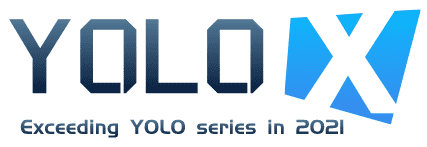

YOLOX is an anchor-free version of YOLO, with a simpler design but better performance! It aims to bridge the gap between research and industrial communities.

# ☀️ Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import ast
import os
import json
import pandas as pd
import torch
import importlib
import cv2 

import shutil
from shutil import copyfile
from tqdm.notebook import tqdm
tqdm.pandas()
from sklearn.model_selection import GroupKFold
from PIL import Image
from string import Template
from IPython.display import display
TRAIN_PATH = '/kaggle/input/tensorflow-great-barrier-reef'

# Check Torch & CUDA 

In [ ]:
print(f"Torch: {torch.__version__}")
!nvcc --version

#  ⬇️ Download YOLOX

In [ ]:
!git clone https://github.com/Megvii-BaseDetection/YOLOX -q

%cd YOLOX
!pip install -U pip && pip install -r requirements.txt
!pip install -v -e . 

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# 🔨 Functions

In [ ]:
def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes
def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row
def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# 🍮 Loading Data

In [ ]:
# Read in the data CSV files
df = pd.read_csv("/kaggle/input/tensorflow-great-barrier-reef/train.csv")
df.head(5)

# BBoxes
##### 📌 Note 
> We can see there are many images without any BBox. 

In [ ]:
df["NumBBox"]=df['annotations'].apply(lambda x: str.count(x, 'x'))
df.head(5)

In [ ]:
print(df["NumBBox"].unique())

In [ ]:
df_train=df[df["NumBBox"]>0]
df_train.sample(2)

In [ ]:
print(df_train['NumBBox'].sum())

> We have just 4919 images with 11898 BBoxs, we will use them in training.

In [ ]:
df_train['annotations'] = df_train['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df_train['bboxes'] = df_train.annotations.progress_apply(get_bbox)
df_train.sample(2)

# Size of Images
##### 📌 Note 
> All images have Width=1280 & Height=720 

In [ ]:
df_train["width"]=1280
df_train["height"]=720
df_train.sample(2)

# Path of Images

In [ ]:
df_train = df_train.progress_apply(get_path, axis=1)
df_train.sample(2)

# 🍚 Splitting Dataset

In [ ]:
n_spl=3
Selected_Fold=2 #0..2

from sklearn.model_selection import GroupKFold
gkf  = GroupKFold(n_splits = n_spl) # num_folds=3 as there are total 3 videos
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df_train, groups = df_train.video_id.tolist())):
    df_train.loc[val_idx, 'fold'] = fold
display(df_train.fold.value_counts())

## 🍚 Organize Directories

I organized train and val images according to the example below.

```
/Kaggle/working
    /dataset
         /images
             /train2017
             /val2017
             /annotations
     /YOLOX
 
    
```

In [ ]:
Work_Dir = '/kaggle/working/' 
DataSet_Path = 'dataset/images'

os.makedirs(f'{Work_Dir}{DataSet_Path}/train2017', exist_ok=True)
os.makedirs(f'{Work_Dir}{DataSet_Path}/val2017', exist_ok=True)
os.makedirs(f'{Work_Dir}{DataSet_Path}/annotations', exist_ok=True)

In [ ]:
for i in tqdm(range(len(df_train))):
    row = df_train.loc[i]
    if row.fold != Selected_Fold:
        copyfile(f'{row.image_path}', f'{Work_Dir}{DataSet_Path}/train2017/{row.image_id}.jpg')
    else:
        copyfile(f'{row.image_path}', f'{Work_Dir}{DataSet_Path}/val2017/{row.image_id}.jpg') 

In [ ]:
print(f'Number of training files: {len(os.listdir(f"{Work_Dir}{DataSet_Path}/train2017/"))}')
print(f'Number of validation files: {len(os.listdir(f"{Work_Dir}{DataSet_Path}/val2017/"))}')

# 🍜 Creating COCO Annitation

In [ ]:
annotion_id = 0

def save_annot_json(json_annotation, filename):
    with open(filename, 'w') as f:
        output_json = json.dumps(json_annotation)
        f.write(output_json)

In [ ]:
def dataset2coco(df, dest_path):
    
    global annotion_id
    
    annotations_json = {
        "info": [],
        "licenses": [],
        "categories": [],
        "images": [],
        "annotations": []
    }
    
    info = {
        "year": "2021",
        "version": "1",
        "description": "COTS dataset - COCO format",
        "contributor": "",
        "url": "https://kaggle.com",
        "date_created": "2021-11-30T15:01:26+00:00"
    }
    annotations_json["info"].append(info)
    
    lic = {
            "id": 1,
            "url": "",
            "name": "Unknown"
        }
    annotations_json["licenses"].append(lic)

    classes = {"id": 0, "name": "starfish", "supercategory": "none"}

    annotations_json["categories"].append(classes)

    
    for ann_row in df.itertuples():
            
        images = {
            "id": ann_row[0],
            "license": 1,
            "file_name": ann_row.image_id + '.jpg',
            "height": ann_row.height,
            "width": ann_row.width,
            "date_captured": "2021-11-30T15:01:26+00:00"
        }
        
        annotations_json["images"].append(images)
        
        bbox_list = ann_row.bboxes
        
        for bbox in bbox_list:
            b_width = bbox[2]
            b_height = bbox[3]
            
            # some boxes in COTS are outside the image height and width
            if (bbox[0] + bbox[2] > 1280):
                b_width = 1280 - bbox[0] 
            if (bbox[1] + bbox[3] > 720):
                b_height = 720 - bbox[1] 
                
            image_annotations = {
                "id": annotion_id,
                "image_id": ann_row[0],
                "category_id": 0,
                "bbox": [bbox[0], bbox[1], b_width, b_height],
                "area": bbox[2] * bbox[3],
                "segmentation": [],
                "iscrowd": 0
            }
            
            annotion_id += 1
            annotations_json["annotations"].append(image_annotations)
        
        
    print(f"Dataset COTS annotation to COCO json format completed! Files: {len(df)}")
    return annotations_json

In [ ]:

# Convert COTS dataset to JSON COCO
train_annot_json = dataset2coco(df_train[df_train.fold != Selected_Fold], f"{Work_Dir}{DataSet_Path}/train2017/")
val_annot_json = dataset2coco(df_train[df_train.fold == Selected_Fold], f"{Work_Dir}{DataSet_Path}/val2017/")

# Save converted annotations
save_annot_json(train_annot_json, f"{Work_Dir}{DataSet_Path}/annotations/train.json")
save_annot_json(val_annot_json, f"{Work_Dir}{DataSet_Path}/annotations/valid.json")


In [ ]:
def draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, classes_dict):
    alpha=0.5
    for i in range(len(bboxes)):
            box = bboxes[i]
            cls_id = int(bbclasses[i])
            score = scores[i]
            if score < confthre:
                continue
            x0 = int(box[0])
            y0 = int(box[1])
            x1 =int(box[0])+ int(box[2])
            y1 = int(box[1])+ int(box[3])

            cv2.rectangle(img, (x0, y0), (x1, y1), (255, 0, 255), 1)
            cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 1), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,0,255), thickness = 2)
         
    return img

# 🌈 Visualizing BBoxes

In [ ]:
COCO_CLASSES = (
  "starfish",
)

scores =[]
confthre=0.5
bbclasses=[]
bboxes=[]

id=1270

imageid=train_annot_json["images"][id]["id"]
file_name=train_annot_json["images"][id]["file_name"]
height=train_annot_json["images"][id]["height"]
width=train_annot_json["images"][id]["width"]
#img=load_image("/kaggle/working/dataset/images/train_cot/"+file_name)
img=load_image(f'{Work_Dir}{DataSet_Path}/train2017/{file_name}')


for i in train_annot_json["annotations"]:
    if i["image_id"]==imageid :
        bboxes.append(i["bbox"])
        scores.append(1)
        bbclasses.append(0)
        
out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, COCO_CLASSES)
display(Image.fromarray(out_image))

# Select a Model
### Standard Models.


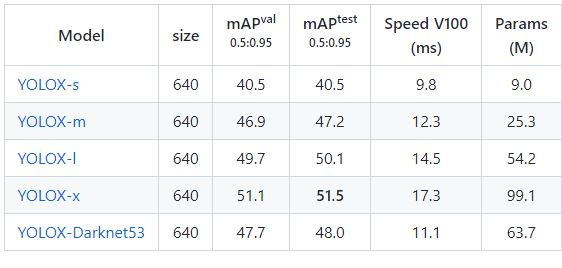

### Light Models.

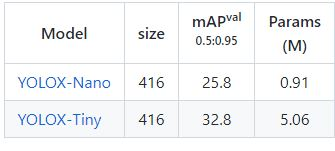

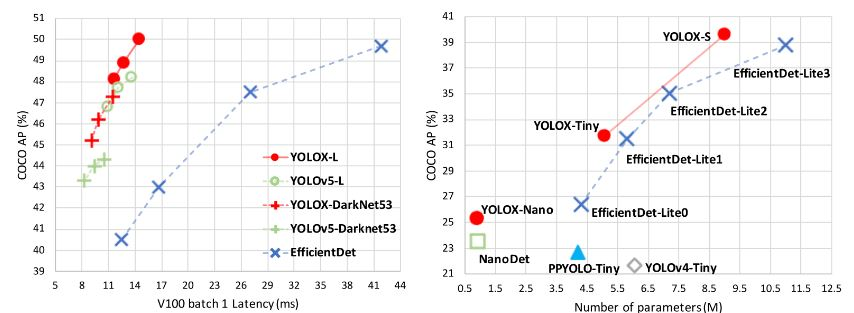

 We will select YOLOX-L Model

# YOLOX-L Experiment Configuration File 
Training parameters could be set up in experiment config files.

In [ ]:
config_file_template = '''

#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# Copyright (c) Megvii, Inc. and its affiliates.

import os

from yolox.exp import Exp as MyExp


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 1.33
        self.width = 1.25
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]
        
        # Define yourself dataset path
        self.data_dir = "/kaggle/working/dataset/images"
        self.train_ann = "train.json"
        self.val_ann = "valid.json"

        self.num_classes = 1

        self.max_epoch = $max_epoch
        self.data_num_workers = 2
        self.eval_interval = 1
        
        self.mosaic_prob = 1.0
        self.mixup_prob = 1.0
        self.hsv_prob = 1.0
        self.flip_prob = 0.5
        self.no_aug_epochs = 2
        
        self.input_size = (960, 960)
        self.mosaic_scale = (0.5, 1.5)
        self.random_size = (10, 20)
        self.test_size = (960, 960)
'''

#### I will train the model for 30 Epochs.

In [ ]:
PIPELINE_CONFIG_PATH='cots_config.py'
pipeline = Template(config_file_template).substitute(max_epoch = 15)
with open(PIPELINE_CONFIG_PATH, 'w') as f:
    f.write(pipeline)

In [ ]:
# ./yolox/data/datasets/voc_classes.py

voc_cls = '''
VOC_CLASSES = (
  "starfish",
)
'''
with open('./yolox/data/datasets/voc_classes.py', 'w') as f:
    f.write(voc_cls)

# ./yolox/data/datasets/coco_classes.py

coco_cls = '''
COCO_CLASSES = (
  "starfish",
)
'''
with open('./yolox/data/datasets/coco_classes.py', 'w') as f:
    f.write(coco_cls)

# check if everything is ok    
!more ./yolox/data/datasets/coco_classes.py

# Getting Weights
We selected  YOLOLX_x

In [ ]:
#%cp -r /kaggle/input/yolox-models /kaggle/working/

sh = 'wget https://github.com/Megvii-BaseDetection/storage/releases/download/0.0.1/yolox_x.pth'
MODEL_FILE = 'yolox_x.pth'

#MODEL_FILE ='/kaggle/input/yolox-models/best_v3_yolox_s.pth.pth'

with open('script.sh', 'w') as file:
  file.write(sh)

!bash script.sh

# Training The Model

In [ ]:
!cp ./tools/train.py ./

In [ ]:
print(os.getcwd())

In [ ]:
!python train.py \
    -f cots_config.py \
    -d 1 \
    -b 4 \
    --fp16 \
    -o \
    -c {MODEL_FILE}

In [ ]:
path = "/kaggle/working/dataset"
shutil.rmtree(path)

### Please if this kernel is useful, <font color='red'>please upvote !!</font>

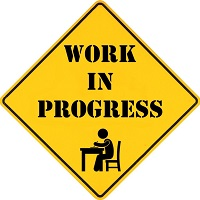

# References

1. https://www.kaggle.com/remekkinas/yolox-training-pipeline-cots-dataset-lb-0-507
1. https://github.com/Megvii-BaseDetection/YOLOX
